# 
Задание: автоматические отчеты
Соберите отчет по результатам ЕГЭ в 2018-2019 году, используя данные
https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv
и отправьте его в HTML формате по адресу support@ittensive.com, используя только Python.
В отчете должно быть:
общее число отличников (учеников, получивших более 220 баллов по ЕГЭ в Москве),
распределение отличников по округам Москвы,
название школы с лучшими результатами по ЕГЭ в Москве.
Диаграмма распределения должна быть вставлена в HTML через data:URI формат (в base64-кодировке).
Дополнительно: приложите к отчету PDF документ того же содержания (дублирующий письмо).
Сколько учеников набрало 220 и больше баллов по ЕГЭ в Москве в 2018-2019 году? 23368

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


(221, b'2.0.0 Closing connection.')

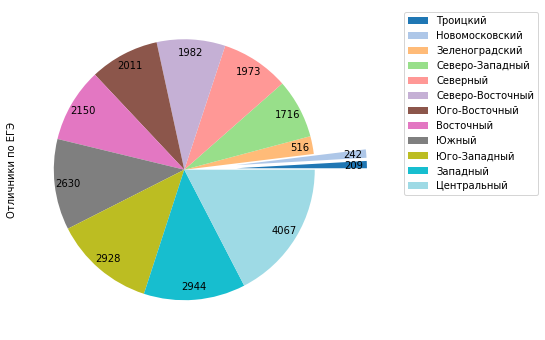

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import pdfkit
from io import BytesIO
import binascii
import smtplib
from email import encoders
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart

data = pd.read_csv("https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv", delimiter=";")
data = data[data["YEAR"] == "2018-2019"]
data_best = data.sort_values("PASSES_OVER_220", ascending=False).head(1)
data["AdmArea"] = data["AdmArea"].apply(lambda x: x.split(" ")[0])
data_adm = data.groupby("AdmArea").sum()["PASSES_OVER_220"].sort_values()
total = data_adm.sum()

fig = plt.figure(figsize=(11,6))
area = fig.add_subplot(1,1,1)
explode = [0]*len(data_adm)
explode[0] = 0.4
explode[1] = 0.4
data_adm.plot.pie(ax = area,
                 labels=[""]*len(data_adm),
                 label="Отличники по ЕГЭ",
                 cmap="tab20",
                 autopct=lambda x:int(round(total * x/100)),
                 pctdistance=0.9,
                 explode=explode)
plt.legend(data_adm.index, bbox_to_anchor=(1.5,1,0.1,0))
img = BytesIO()
plt.savefig(img)
img = 'data:image/png;base64,' + binascii.b2a_base64(img.getvalue(),
                            newline=False).decode("UTF-8")
pd.set_option("display.max_colwidth", 1000)

html = '''<html>
<head>
    <title>Результаты ЕГЭ Москвы: отличники</title>
    <meta charset="utf-8"/>
</head>
<body>
    <h1>Результаты ЕГЭ Москвы: отличники в 2018-2019 году</h1>
    <p>Всего: ''' + str(total) + '''</p>
    <img src="''' + img + '''" alt="Отличники по округам"/>
    <p>Лучшая школа: ''' + str(data_best["EDU_NAME"].values[0]) + '''</p>
</body>
</html>'''
config = pdfkit.configuration(wkhtmltopdf="C:/Program Files/wkhtmltopdf/bin/wkhtmltopdf.exe")
options = {
    'page-size': 'A4',
    'header-right': '[page]'
}
pdfkit.from_string(html, 'ege.best.pdf',
                   configuration=config, options=options)

letter = MIMEMultipart()
letter["From"] = "Николай"
letter["Subject"] = "Результаты по ЕГЭ в Москве"
letter["Content-Type"] = "text/html; charset=utf-8"
letter["To"] = "support@ittensive.com"
letter.attach(MIMEText(html, "html"))
attachement = MIMEBase("application", "pdf")
attachement.set_payload(open("ege.best.pdf", "rb").read())
attachement.add_header("Content-Disposition",
                      'attachement; filename="ege.best.pdf"')
encoders.encode_base64(attachement)
letter.attach(attachement)
# user = "XXX"
# password = "XXX"
server = smtplib.SMTP_SSL("smtp.yandex.com", 465)
server.login(user, password)
server.sendmail("n@ittensive.com",
               "support@ittensive.com",
               letter.as_string())
server.quit()